In [147]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [148]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [149]:
len(words)

32033

In [150]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [151]:
# build dataset
#size of the context
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # get integer value of char
            X.append(context) # add current context to X, the set of all contexts
            Y.append(ix) # add char after context to Y, the output based on corresponding context
            context = context[1:] + [ix] # drop the first thing in the context and add the last to the end
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

#make training, validation, and test training sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [152]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * .01 # so that w2 is small numbers, reducing size of logits at init and reducing loss at init
b2 = torch.randn(vocab_size,                      generator=g) * 0 #so that b2 is 0 at initialization, making loss at init better

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [153]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = .1 if i < 100000 else .01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1877
  20000/ 200000: 2.4270
  30000/ 200000: 2.6032
  40000/ 200000: 2.0712
  50000/ 200000: 2.4562
  60000/ 200000: 2.4073
  70000/ 200000: 2.1389
  80000/ 200000: 2.3659
  90000/ 200000: 2.0872
 100000/ 200000: 1.8262
 110000/ 200000: 2.2224
 120000/ 200000: 1.8486
 130000/ 200000: 2.5117
 140000/ 200000: 2.1848
 150000/ 200000: 2.1080
 160000/ 200000: 1.9327
 170000/ 200000: 1.8609
 180000/ 200000: 2.0279
 190000/ 200000: 1.8962


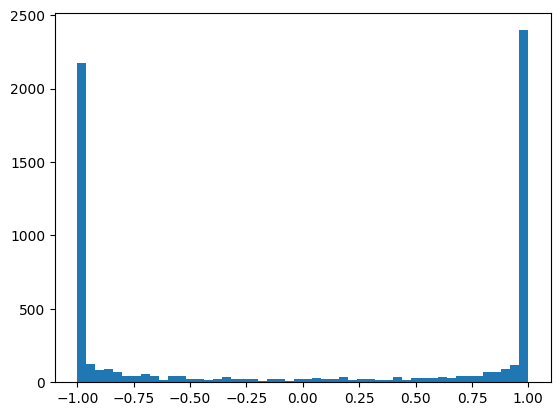

In [154]:
plt.hist(h.view(-1).tolist(), 50);

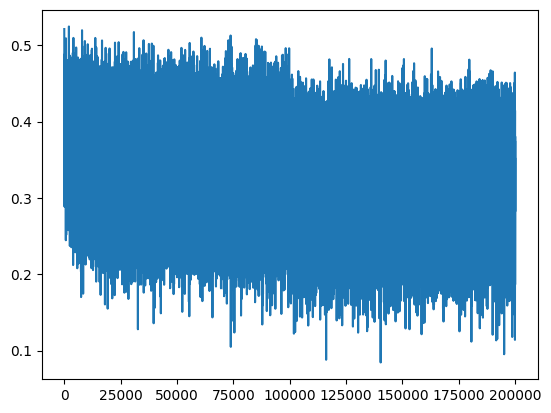

In [155]:
plt.plot(lossi)

In [156]:
# testing out why setting weights and biases randomly(which affect logits), is bad for initial loss, because at initialization
# every char should have equal probablity
#logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ -9.0640,   4.6956,  -8.2148, -11.3768]),
 tensor([1.0576e-06, 1.0000e+00, 2.4723e-06, 1.0467e-07]),
 tensor(12.9104))

In [157]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.07080340385437
val 2.132983446121216


In [158]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # concatenate the vectors
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
ndalyah.
ren.
rucendraegusterronelin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshirael.
kin.
renlynn.
novana.
ubelled.
ryyah.
fael.
